In [46]:
import librosa 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import IPython.display as ipd 
import os,shutil
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip, concatenate_videoclips

In [47]:
SAMPLES_DIR="../samples/"
ETC_DIR=SAMPLES_DIR+"etc/"
AUDIO_DIR=SAMPLES_DIR+"audio/"
OUT_DIR=SAMPLES_DIR+"out/"
VIDEO_NAME="video.mp4"
AUDIO_NAME="video.wav"

In [48]:
#Enter your audio file name of match here. .wav,.mp3, etc. are supported.
vid, sample_rate = librosa.load(AUDIO_DIR+AUDIO_NAME,sr=16000)
print(int(librosa.get_duration(y=vid, sr=sample_rate)/60))

4


In [49]:
#Breaking down video into chunks of 5 seconds so that rise in energy can be found.
chunk_size=5 
window_length = chunk_size * sample_rate

500.5263350745663


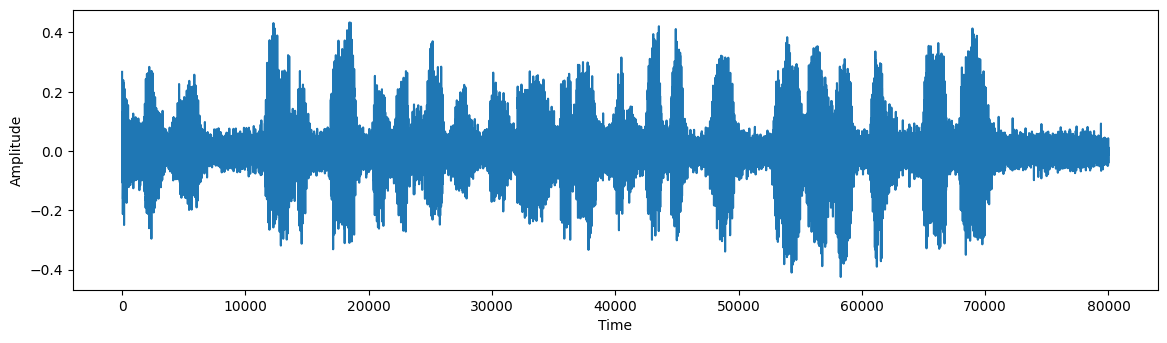

In [50]:
#seeing an audio sample and it's time-amplitude graph
a=vid[5*window_length:6*window_length] 
ipd.Audio(a, rate=sample_rate)
energy = sum(abs(a**2))
print(energy)
fig = plt.figure(figsize=(14, 8)) 
ax1 = fig.add_subplot(211) 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Amplitude') 
ax1.plot(a)

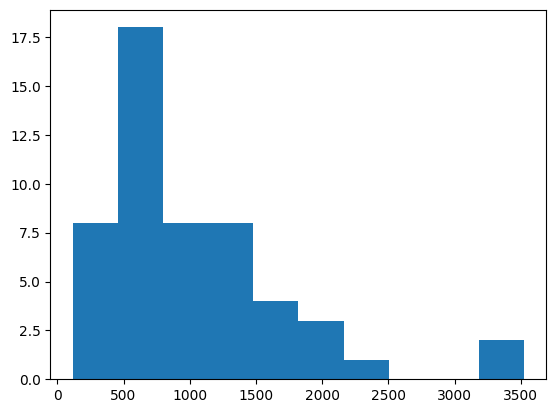

In [51]:
#Plotting short time energy distribution histogram of all chunks
energy = np.array([sum(abs(vid[i:i+window_length]**2)) for i in range(0, len(vid), window_length)])
plt.hist(energy) 
plt.show()
#Close graphs for progress of program

In [52]:
#Finding and setting threshold value of commentator and audience noise above which we want to include portion in highlights.
df=pd.DataFrame(columns=['energy','start','end'])
thresh=800
row_index=0
for i in range(len(energy)):
	value=energy[i]
	if(value>=thresh):
		i=np.where(energy == value)[0]
		df.loc[row_index,'energy']=value
		df.loc[row_index,'start']=i[0] * 5
		df.loc[row_index,'end']=(i[0]+1) * 5
		row_index= row_index + 1

In [53]:
df

,energy,start,end
0,2139.67717,45,50
1,1219.747588,50,55
2,1034.45764,55,60
3,875.920918,60,65
4,827.63331,75,80
5,1561.211774,80,85
6,1230.988698,85,90
7,1426.70082,90,95
8,1455.666112,95,100
9,3240.487621,100,105


In [54]:
#Merge consecutive time intervals of audio clips into one.
temp=[]
i,j,n=0,0,len(df) - 1
while(i<n):
	j=i+1
	while(j<=n):
		if(df['end'][i] == df['start'][j]):
			df.loc[i,'end'] = df.loc[j,'end']
			temp.append(j)
			j=j+1
		else:
			i=j
			break  
df.drop(temp,axis=0,inplace=True)

In [55]:
df

,energy,start,end
0,2139.67717,45,65
4,827.63331,75,125
14,838.820517,130,135
15,3522.687104,160,190
21,914.407839,195,215
25,1065.17051,230,235


In [56]:
#Extracting subclips from the video file on the basis of energy profile obtained from audio file.
start=np.array(df['start'])
end=np.array(df['end'])

In [57]:
df['start']

0      45
4      75
14    130
15    160
21    195
25    230
Name: start, dtype: object

In [58]:
df['end']

0      65
4     125
14    135
15    190
21    215
25    235
Name: end, dtype: object

In [59]:
#Create temporary folder for storing subclips generated. This folder will be deleted later after highlights are generated. 
sub_folder=os.path.join(ETC_DIR,"Subclips")
if os.path.exists(sub_folder):
	shutil.rmtree(sub_folder)
	path=os.mkdir(sub_folder)
else:
	path=os.mkdir(sub_folder)
#print(sub_folder,type(sub_folder))

In [60]:
#Extract moments from videos to be added in highlight
print(df)
for i in range(len(df)):
	if(i!=0):
		start_lim = start[i] - 5  #Assuming that noise starts after the shot, so set start point as t-5 seconds to include the shot/wicket action.
	else:
		start_lim = start[i] 
	end_lim   = end[i]   
	filename="highlight" + str(i+1) + ".mp4"
	ffmpeg_extract_subclip(SAMPLES_DIR+VIDEO_NAME,start_lim,end_lim,targetname=sub_folder+"/"+filename) #Enter your sports video clip name here.

         energy start  end
0    2139.67717    45   65
4     827.63331    75  125
14   838.820517   130  135
15  3522.687104   160  190
21   914.407839   195  215
25   1065.17051   230  235
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [61]:
files=os.listdir(sub_folder)
files=[sub_folder+"/highlight" + str(i+1) + ".mp4" for i in range(len(df))]
#print(files)
final_clip=concatenate_videoclips([VideoFileClip(i) for i in files])
final_clip.write_videofile(OUT_DIR+VIDEO_NAME) #Enter the desired output highlights filename.
shutil.rmtree(sub_folder) #Delete the temporary file.

Moviepy - Building video ../samples/out/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../samples/out/video.mp4



Moviepy - Done !
Moviepy - video ready ../samples/out/video.mp4
